In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
folder_path = '/content/drive/MyDrive'
backtest = (f'{folder_path}/ML&fintech/因子回測/')
data_path = (f'{folder_path}/ML&fintech/BTCUSDT_PERPETUAL.h5')


### using origin data from market, like OHLCV

In [3]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_hdf(data_path)
# data['rtn1min'] = np.where(data['close'] - data['close'].shift(1) > 0, 1, 0)
# data['rtn5min'] = np.where(data['close'] - data['close'].shift(5) > 0, 1, 0)
# data['rtn10min'] = np.where(data['close'] - data['close'].shift(10) > 0, 1, 0)
# data['rtn30min'] = np.where(data['close'] - data['close'].shift(30) > 0, 1, 0)
# data['rtn60min'] = np.where(data['close'] - data['close'].shift(60) > 0, 1, 0)
data['rtn1hr'] = np.where(data['close'].shift(-60) - data['close'] > 0, 1, 0)
# data['rtn2hr'] = np.where(data['close'] - data['close'].shift(120) > 0, 1, 0)
# data['rtn4hr'] = np.where(data['close'] - data['close'].shift(240) > 0, 1, 0)
# data['rtn6hr'] = np.where(data['close'] - data['close'].shift(360) > 0, 1, 0)
# data['rtn12hr'] = np.where(data['close'] - data['close'].shift(720) > 0, 1, 0)
# data['rtn1day'] = np.where(data['close'] - data['close'].shift(1440) > 0, 1, 0)
# data['rtn3day'] = np.where(data['close'] - data['close'].shift(4320) > 0, 1, 0)
factor_list = os.listdir(backtest)


prepared_data = [data]
for f in ['rsi','amount_srpead','bar_rtn_sum','volatility_0','price_vol_corr','zscore','x_s_ratio','high_low_dis','mom']:
    factor_lbps = os.listdir(f'{backtest}{f}/')
    for factor_lbp in factor_lbps:
        factor_data = pd.read_hdf(f'{backtest}{f}/{factor_lbp}')
        # factor_data = factor_data.to_frame()
        factor_data = factor_data.drop(columns=['pnl','exit_long','exit_short'])
        factor_data = factor_data.dropna()
        factor_data = factor_data.replace({True: 1, False: 0})
        # factor_data = factor_data.rename(columns={factor_data.columns: factor_lbp.split('.h5')[0]})
        factor_data.columns = [factor_lbp.split('.h5')[0] + '_' + col for col in factor_data.columns]
        prepared_data.append(factor_data)
    output = pd.concat(prepared_data,axis=1)
    output = output.dropna()
    data_subset = output.drop(['close_time'], axis=1)


In [4]:
from sklearn.decomposition import PCA
import pandas as pd

def turn_PCA(df):
    # Perform PCA to reduce to 3 dimensions
    pca = PCA(n_components=len(df.columns))

    # Fit and transform the data
    principal_components = pca.fit_transform(df)

    # Calculate PVE for the principal components
    explained_variance_ratio = pca.explained_variance_ratio_

    # Create a new DataFrame with the principal components
    columns = [f'PC{i+1}' for i in range(len(df.columns))]
    pc_df = pd.DataFrame(data=principal_components, columns=columns)

    return pc_df, explained_variance_ratio

# Assuming data_subset is your DataFrame
return_data = data_subset['rtn1hr']
data_subset = data_subset.drop(columns=['rtn1hr'])
pca, explained_variance_ratio = turn_PCA(data_subset)

# Display the principal components DataFrame
#print(pca)


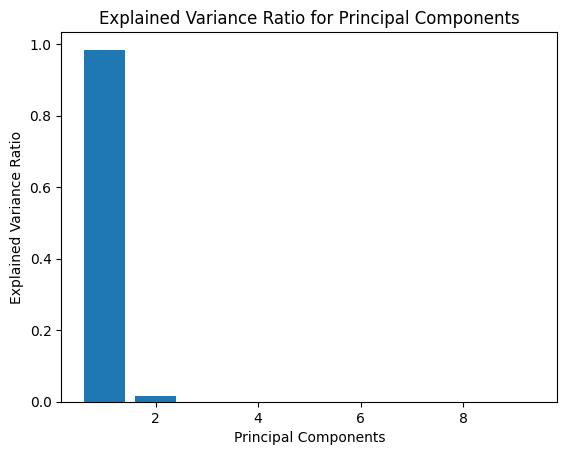

In [5]:
import matplotlib.pyplot as plt

# Assuming explained_variance_ratio is a NumPy array obtained from the turn_PCA function
# Also, assuming you have already called turn_PCA on your data

# Plot the explained variance ratio
plt.bar(range(1, 10), explained_variance_ratio[0:9], align='center')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Principal Components')
plt.show()


In [6]:
PVE1 = explained_variance_ratio[0]
PVE2 = explained_variance_ratio[1]
PVE3 = explained_variance_ratio[2]
PVE4 = explained_variance_ratio[3]
PVE5 = explained_variance_ratio[4]

print("Proportion of Variance Explained (PVE) for PC1:", PVE1)
print("Proportion of Variance Explained (PVE) for PC2:", PVE2)
print("Proportion of Variance Explained (PVE) for PC3:", PVE3)
print("Proportion of Variance Explained (PVE) for PC4:", PVE4)
print("Proportion of Variance Explained (PVE) for PC5:", PVE5)

Proportion of Variance Explained (PVE) for PC1: 0.9847721605154646
Proportion of Variance Explained (PVE) for PC2: 0.015227678278119166
Proportion of Variance Explained (PVE) for PC3: 1.595094682408589e-07
Proportion of Variance Explained (PVE) for PC4: 1.667491015883105e-09
Proportion of Variance Explained (PVE) for PC5: 2.8728702681541078e-11


In [7]:
# Get the index from df1
index_values = data_subset.index
pca['Index'] = index_values
pca.set_index('Index', inplace=True)
pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147
Index,,,,,,,,,,,,,,,,,,,,,
2022-12-22 20:31:00,6.343682e+06,2.235273e+06,18478.870740,-220.601500,225.625568,51.412273,1.794686,0.593797,-4.695592,2.397703,...,0.000311,-0.000044,-8.858379e-09,-6.955897e-09,-2.285350e-09,-1.910198e-09,-1.133445e-09,-6.877159e-09,2.730113e-10,2.666513e-11
2022-12-22 20:32:00,4.345049e+06,-2.276374e+05,18400.081340,-362.518213,180.884691,-2.467778,-4.328364,-1.708060,-4.673429,2.275892,...,0.000553,-0.000053,-1.766578e-09,-2.722460e-09,1.676830e-09,1.289298e-10,7.054042e-10,-5.326744e-10,2.102528e-09,6.026042e-12
2022-12-22 20:33:00,-1.212522e+06,1.201078e+06,18311.267704,-291.696758,64.098775,27.375819,1.581527,-1.093460,-2.673765,2.490799,...,0.000523,-0.000131,2.219408e-10,3.574104e-10,-4.503923e-10,2.853049e-10,-1.468342e-11,7.927708e-10,-1.208710e-09,7.688218e-12
2022-12-22 20:34:00,1.624683e+07,5.885944e+06,18790.858704,814.452308,448.521272,133.301858,-6.831188,3.413385,-3.073755,3.075760,...,0.000551,-0.000101,1.479525e-09,1.001787e-09,-1.539719e-09,8.225426e-10,1.969521e-10,4.183544e-10,2.205057e-10,-2.812066e-11
2022-12-22 20:35:00,1.819601e+06,-4.748181e+05,18381.986393,-310.495054,128.167874,-8.357694,-5.874390,-1.433349,-2.098278,1.970198,...,0.000600,0.000079,-4.872296e-10,-1.680777e-09,5.463114e-10,-6.342655e-11,1.025901e-09,-1.166088e-09,2.077002e-09,-4.452827e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-19 12:57:00,-7.951315e+06,1.695319e+05,-74.136746,603.715507,2.503535,0.343576,-0.359977,-3.244711,-0.023333,-0.018805,...,-0.000075,0.000060,-1.379937e-11,-1.129834e-10,4.009676e-11,2.067858e-11,1.036935e-10,-5.486765e-11,1.325517e-10,3.929109e-15
2023-08-19 12:58:00,-8.102400e+06,3.951208e+05,-70.269795,158.837617,-1.583424,0.318147,5.428638,1.100822,0.334030,0.162483,...,-0.000088,0.000090,-9.666531e-11,-4.904231e-10,8.901134e-11,-3.999498e-11,3.883850e-10,-3.450387e-10,5.338840e-10,1.281827e-13
2023-08-19 12:59:00,-8.695874e+06,1.457298e+05,-70.076329,535.526724,1.547098,0.298482,-0.635363,-3.468140,-0.067084,-0.093035,...,-0.000155,0.000109,-1.007509e-11,-9.414795e-11,4.477339e-11,2.900392e-11,8.466975e-11,-4.500212e-11,1.385116e-10,-7.968521e-14


Index(['open', 'high', 'low', 'close', 'volume', 'quote_volume', 'trades_num',
       'taker_buy_volume', 'taker_buy_quote_volume', 'rsi_6hour_long',
       ...
       'mom_30min_long', 'mom_30min_short', 'mom_5min_long', 'mom_5min_short',
       'mom_12hour_long', 'mom_12hour_short', 'mom_1min_long',
       'mom_1min_short', 'mom_6hour_long', 'mom_6hour_short'],
      dtype='object', length=147)
Model Accuracy: 0.7080
Precision: 0.7107
Recall: 0.7088
F1-Score: 0.7098


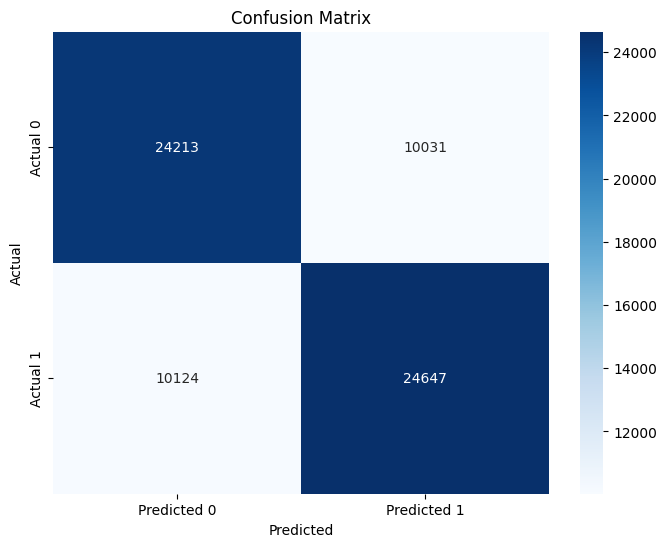

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import xgboost as xgb

# Assuming X and y are defined
n=158
X = data_subset
y = return_data

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create XGBoost classification model
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions using the model
y_pred = model.predict(X_test)

feature_importances = model.feature_importances_
print(X.columns)
# 創建一個DataFrame來顯示特徵和它們的重要性
features_df = pd.DataFrame({
    'Feature': [f'{i}' for i in X.columns],
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=False)
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
#print(f"{n} principle component")
print(f"Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()



In [12]:
features_df['Importance']

0      0.008331
1      0.011270
2      0.010977
3      0.010913
4      0.002386
         ...   
153    0.010463
154    0.000000
155    0.000000
156    0.011911
157    0.006666
Name: Importance, Length: 158, dtype: float32

XGBoost


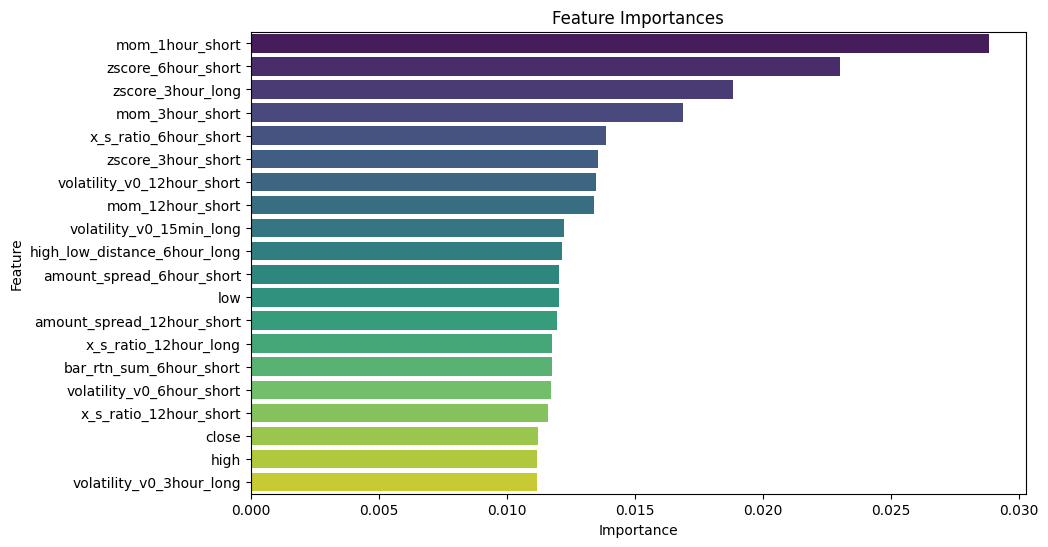

In [9]:
features_df = features_df.sort_values(by='Importance', ascending=False)
# Plot feature importances as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df[:20], palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
print("XGBoost")
plt.show()

### 邏輯回歸

Logistic regression
Model Accuracy: 0.5090
Precision: 0.5100
Recall: 0.6490
F1-Score: 0.5712


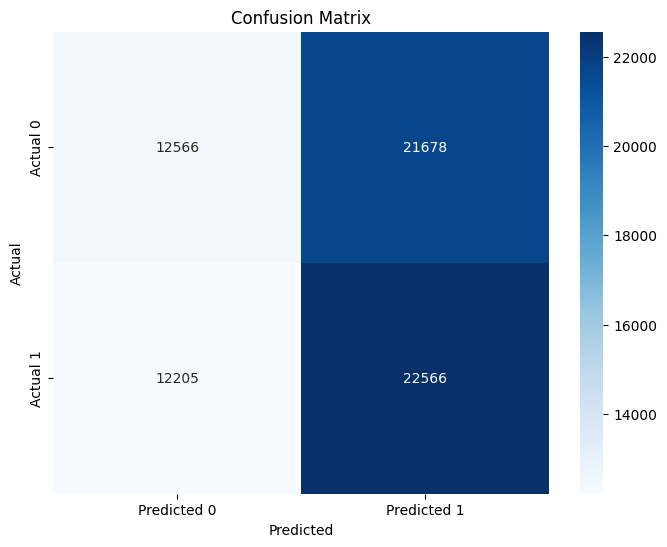

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Assuming X and y are defined
n=150
X = data_subset
y = return_data

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 創建邏輯回歸模型
model = LogisticRegression()

# 訓練模型
model.fit(X_train, y_train)

# 用測試集評估模型
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Logistic regression")
print(f"Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()


Index(['open', 'high', 'low', 'close', 'volume', 'quote_volume', 'trades_num',
       'taker_buy_volume', 'taker_buy_quote_volume', 'rsi_6hour_long',
       ...
       'mom_30min_long', 'mom_30min_short', 'mom_5min_long', 'mom_5min_short',
       'mom_12hour_long', 'mom_12hour_short', 'mom_1min_long',
       'mom_1min_short', 'mom_6hour_long', 'mom_6hour_short'],
      dtype='object', length=147)
100 principle component
Model Accuracy: 0.8820
Precision: 0.8882
Recall: 0.8761
F1-Score: 0.8821


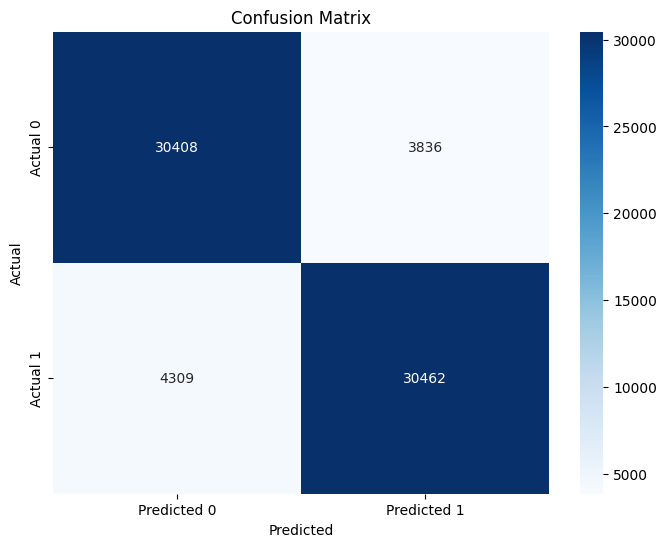

In [11]:
from sklearn.ensemble import RandomForestClassifier
# Assuming X and y are defined
n=100
X = data_subset
y = return_data

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 創建隨機森林模型
rf_model = RandomForestClassifier(random_state=42)

# 訓練模型
rf_model.fit(X_train, y_train)

# 用測試集評估模型
y_pred = rf_model.predict(X_test)

feature_importances = rf_model.feature_importances_
print(X.columns)
# 創建一個DataFrame來顯示特徵和它們的重要性
features_df = pd.DataFrame({
    'Feature': [f'{i}' for i in X.columns],
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=False)
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"{n} principle component")
print(f"Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()


Index(['open', 'high', 'low', 'close', 'volume', 'quote_volume', 'trades_num',
       'taker_buy_volume', 'taker_buy_quote_volume', 'rtn1min',
       ...
       'high_low_distance_30min_long', 'high_low_distance_30min_short',
       'high_low_distance_1min_long', 'high_low_distance_1min_short',
       'high_low_distance_5min_long', 'high_low_distance_5min_short',
       'high_low_distance_6hour_long', 'high_low_distance_6hour_short',
       'high_low_distance_12hour_long', 'high_low_distance_12hour_short'],
      dtype='object', length=142)


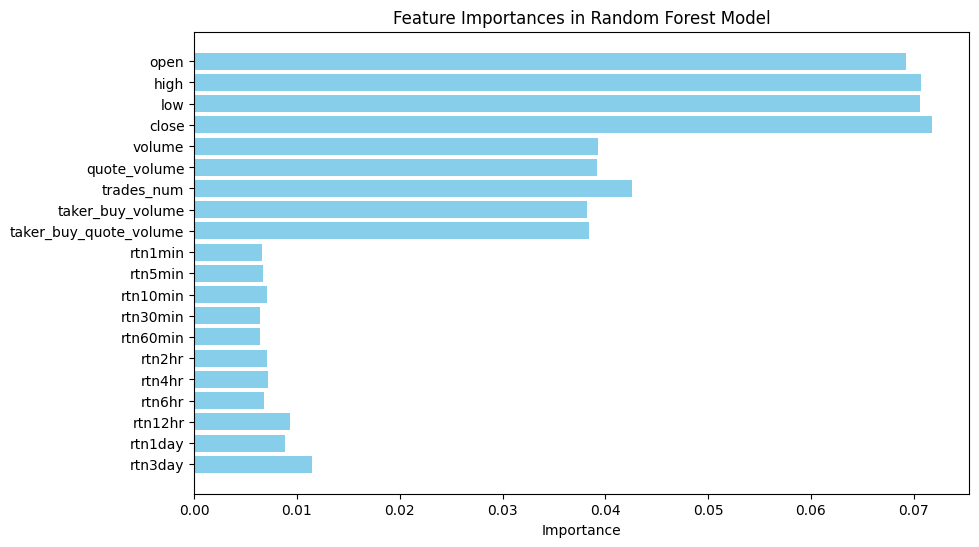

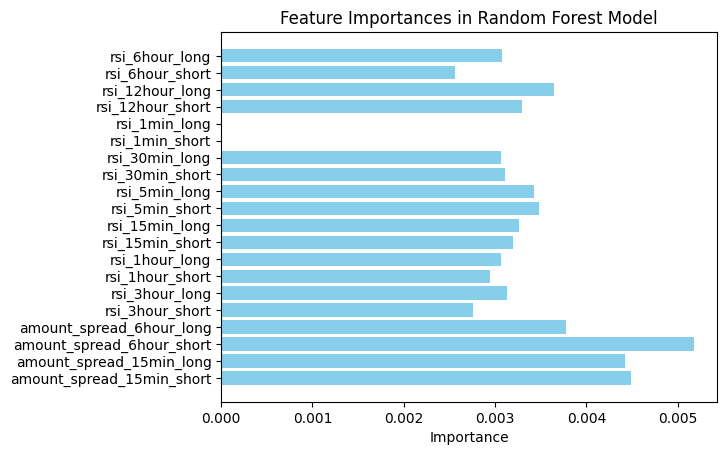

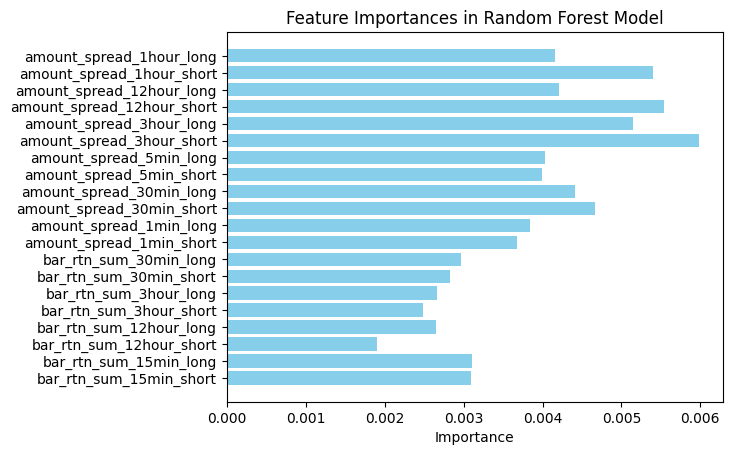

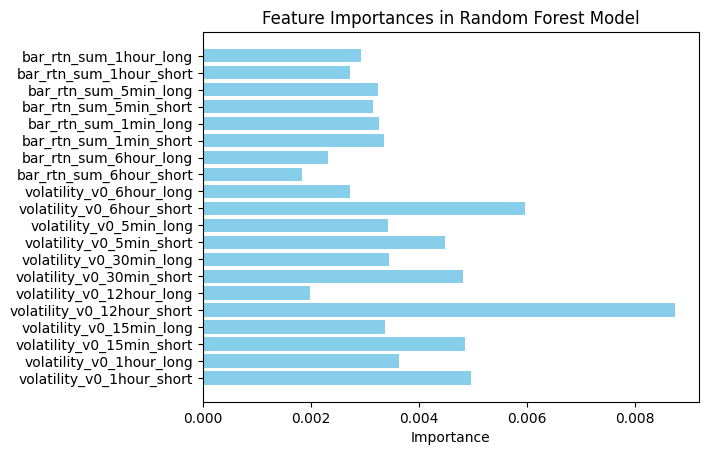

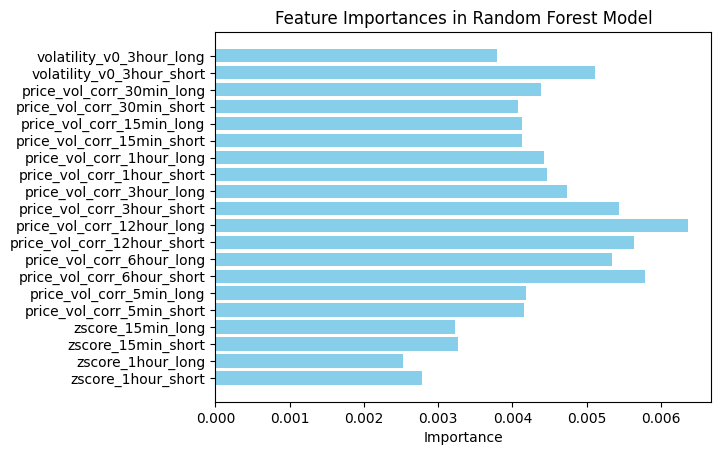

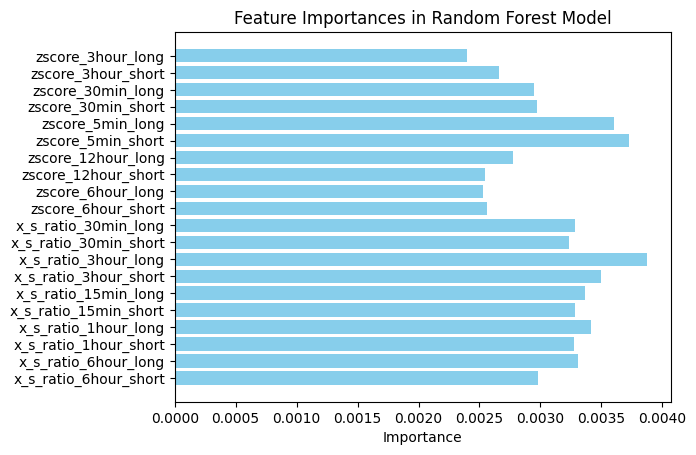

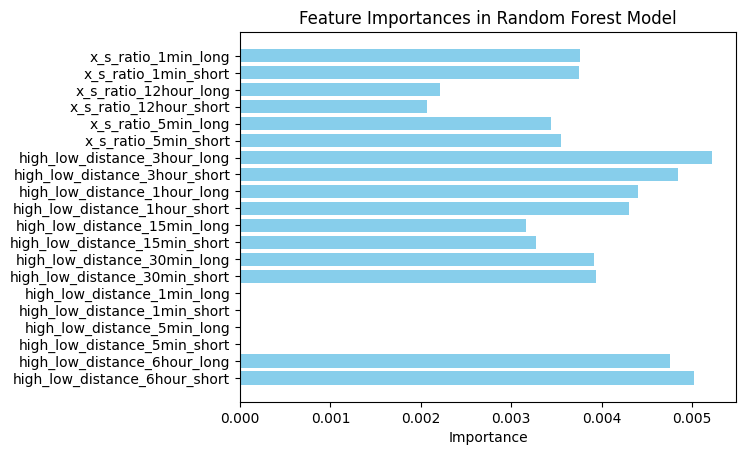

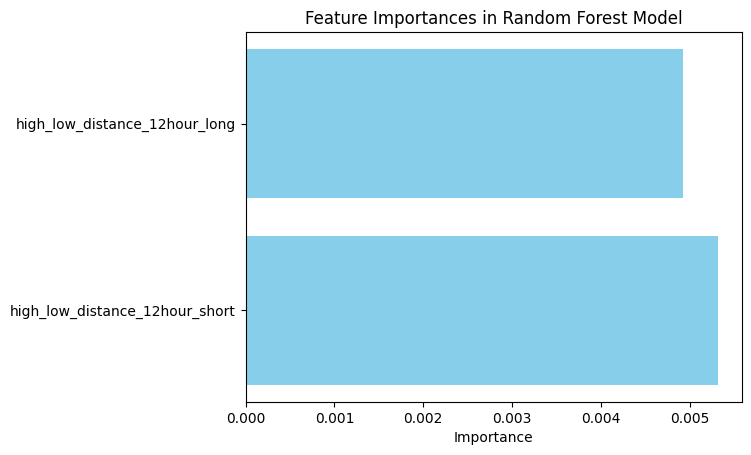

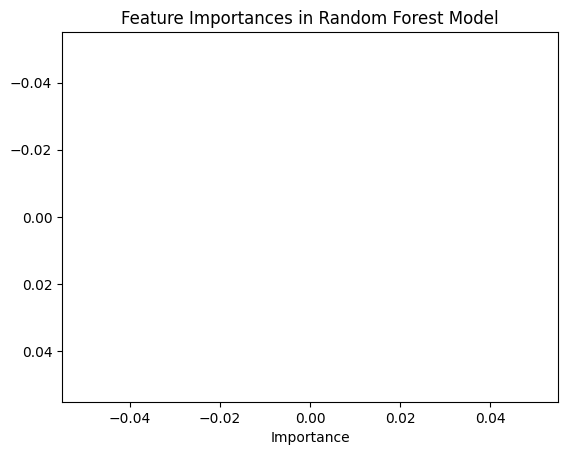

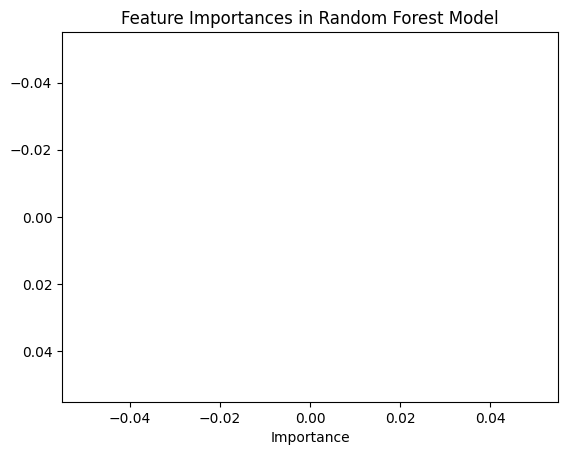

In [ ]:
feature_importances = rf_model.feature_importances_
print(X.columns)
# 創建一個DataFrame來顯示特徵和它們的重要性
features_df = pd.DataFrame({
    'Feature': [f'{i}' for i in X.columns],
    'Importance': feature_importances
})

features_df.sort_values(by='Importance', ascending=False)


# Get the feature importances again
importances_adjusted = rf_model.feature_importances_

# Plotting the feature importances with adjusted feature names
plt.figure(figsize=(10, 6))
for i in range(10):
  plt.barh(X.columns[i*20:i*20+20], importances_adjusted[i*20:i*20+20], color='skyblue')
  plt.xlabel('Importance')
  plt.title('Feature Importances in Random Forest Model')
  plt.gca().invert_yaxis()
  plt.show()

# # Re-plotting the confusion matrix using the updated predictions
# y_pred_scaled = rf_model.predict(X_test_scaled)
# conf_matrix_scaled = confusion_matrix(y_test, y_pred_scaled)

# plt.figure(figsize=(6, 6))
# sns.heatmap(conf_matrix_scaled, annot=True, fmt='d', cmap='Blues', square=True)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()
# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')